# Simple CNN Model for Base Scores - Data Augmentation method

In [1]:
from PIL import Image
import os

data_dir = "homus_data"
class_folders = os.listdir(data_dir)

images = []
labels = []

for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(data_dir, class_folder)
    image_files = os.listdir(class_path)
    
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path).convert("L")  # Convert to gray
        images.append(image)
        labels.append(i)  


In [2]:
import numpy as np

target_size = (96, 96)  # Adjust the size
normalized_images = []

for image in images:
    resized_image = image.resize(target_size)
    normalized_image = np.array(resized_image) / 255.0  # Normalize values
    normalized_images.append(normalized_image)

In [3]:
total_data = len(labels)
print("Total number of instances:", total_data)

Total number of instances: 15200


In [4]:
num_classes = len(class_folders)
print("Number of classes:", num_classes)

Number of classes: 32


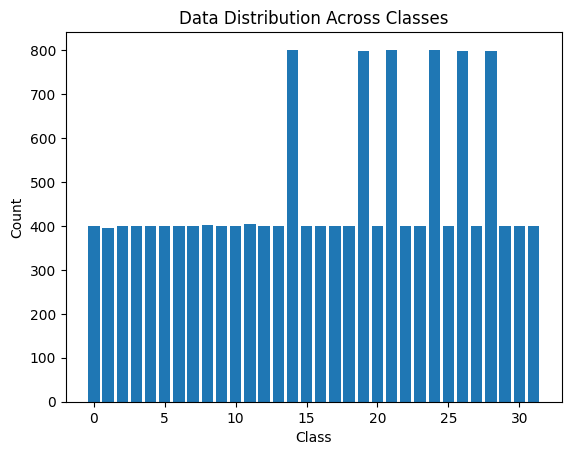

In [5]:
import matplotlib.pyplot as plt

class_counts = [labels.count(i) for i in range(num_classes)]

# Plot the distribution of data across labels
plt.bar(range(num_classes), class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Distribution Across Classes')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(normalized_images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


In [7]:
train_data = len(X_train)
test_data = len(X_test)
print("Number of instances for training:", train_data)
print("Number of instances for testing:", test_data)

Number of instances for training: 12160
Number of instances for testing: 1520


In [8]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

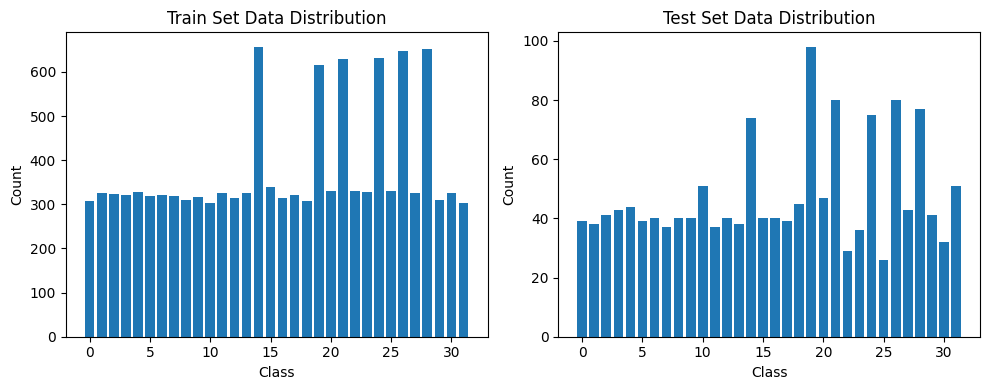

In [9]:
train_class_counts = [y_train.tolist().count(i) for i in range(num_classes)]
test_class_counts = [y_test.tolist().count(i) for i in range(num_classes)]

# Plot the data distribution in the training and testing sets
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(num_classes), train_class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train Set Data Distribution')
plt.subplot(1, 2, 2)
plt.bar(range(num_classes), test_class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Test Set Data Distribution')
plt.tight_layout()
plt.show()

In [10]:
from keras.utils import to_categorical

X_train = X_train.reshape(X_train.shape[0], target_size[0], target_size[1], 1)
X_val = X_val.reshape(X_val.shape[0], target_size[0], target_size[1], 1)
X_test = X_test.reshape(X_test.shape[0], target_size[0], target_size[1], 1)
y_train_ = to_categorical(y_train.reshape(-1, 1))
y_test_ = to_categorical(y_test.reshape(-1, 1))
y_val_ = to_categorical(y_val.reshape(-1, 1))

Define the CNN model with keras layers

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers

class CNNModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        
    def build_model(self):
        #1
        model = tf.keras.Sequential()
        
        ## We could add pading layers as below
        #model.add(layers.ZeroPadding2D(padding=(2, 2)))
        ## But, while we can choose the padding directly through the conv2d layer, we find it trivial to add this layer.
        
        #2, 3, 4
        model.add(layers.Conv2D(48, (3, 3), activation='relu', input_shape=self.input_shape, padding='same', strides=(2, 2)))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
        
        #5, 6, 7
        model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same', strides=(1, 1)))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
        
        #8, 9
        model.add(layers.Conv2D(48, (5, 5), activation='relu', padding='same', strides=(1, 1)))
        
        #10, 11
        model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same', strides=(1, 1)))
        
        #12, 13, 14
        model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same', strides=(1, 1)))
        model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
        
        #15, 16, 17
        model.add(layers.Flatten())
        model.add(layers.Dense(1000, activation='relu'))
        model.add(layers.Dropout(0.5))
        
        #18, 19
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        learning_rate = 0.0001
        optimizer = optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return model

    def summary(self):
        self.model.summary()

    def create_model(self):
        if self.model is None:
            self.model = self.build_model()
            
    def train(self, x_train, y_train, epochs, batch_size, validation_split):
        self.create_model()
        history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = validation_split)
        
        # Recoed loss for plot and confussion matrix
        self.train_loss_history += history.history['loss']
        self.val_loss_history += history.history['val_loss']
        
        # Recoed accuracy for plot and confussion matrix
        self.train_acc_history += history.history['accuracy']
        self.val_acc_history += history.history['val_accuracy']
    
    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)

    def plot_loss_history(self):
        plt.plot(self.train_loss_history, label='Training Loss')
        plt.plot(self.val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def plot_accuracy_history(self):
        plt.plot(self.train_acc_history, label='Training Accuracy')
        plt.plot(self.val_acc_history, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
    
    def plot_confusion_matrix(self, x_test, y_test):
        y_pred = self.model.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        cm = confusion_matrix(y_true_classes, y_pred_classes)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

In [12]:
input_shape = (target_size[0], target_size[1], 1)
num_classes = len(class_folders)

model = CNNModel(input_shape, num_classes)

In [13]:
epochs = 70
batch_size = 128
validation_split = 0.1

Apply the CNN network

In [28]:
model.train(X_train, y_train_, epochs, batch_size, validation_split)

Epoch 1/5
86/86 [==============================] - 38s 422ms/step - loss: 3.4211 - accuracy: 0.0543 - val_loss: 3.3652 - val_accuracy: 0.0765
Epoch 2/5
86/86 [==============================] - 42s 487ms/step - loss: 2.9628 - accuracy: 0.1415 - val_loss: 2.3616 - val_accuracy: 0.2911
Epoch 3/5
86/86 [==============================] - 43s 496ms/step - loss: 2.3058 - accuracy: 0.2950 - val_loss: 1.8857 - val_accuracy: 0.4581
Epoch 4/5
86/86 [==============================] - 47s 544ms/step - loss: 1.9244 - accuracy: 0.4031 - val_loss: 1.6108 - val_accuracy: 0.5156
Epoch 5/5
86/86 [==============================] - 49s 571ms/step - loss: 1.7039 - accuracy: 0.4610 - val_loss: 1.4173 - val_accuracy: 0.5757


Plot loss and accuracy accross the training and validation datasets

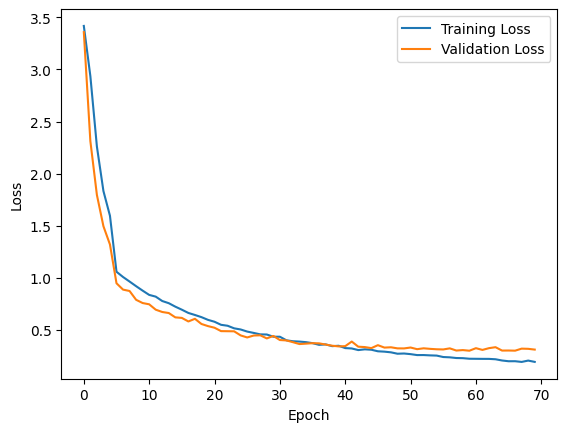

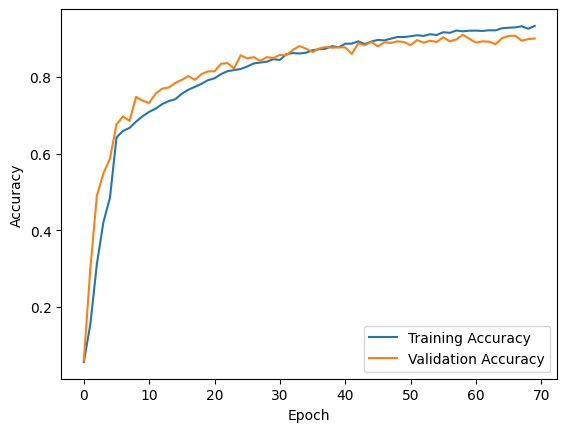

In [39]:
model.plot_loss_history()
model.plot_accuracy_history()

48/48 [==============================] - 1s 25ms/step


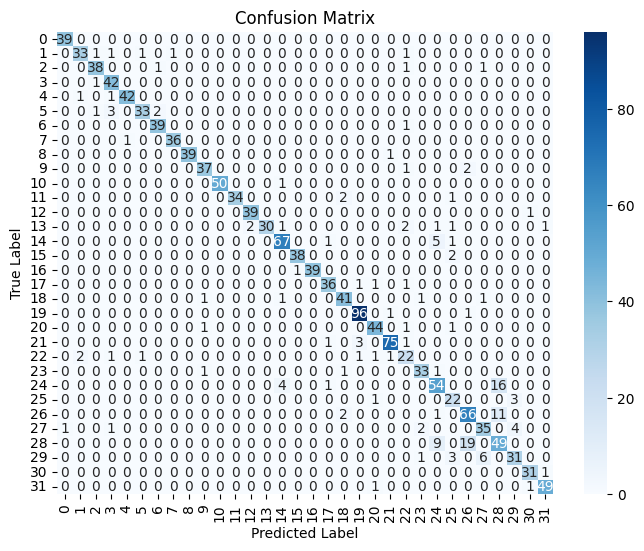

In [28]:
model.plot_confusion_matrix(X_test, y_test_)

Evaluate the model on the training set

In [29]:
model.evaluate(X_test, y_test_)

48/48 [==============================] - 1s 25ms/step - loss: 0.2979 - accuracy: 0.8941


[0.29790234565734863, 0.8940789699554443]

In [14]:
class CNNModelAug(CNNModel):
    
    def train(self, train_dataset, epochs, validation_data):
        self.create_model()
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=validation_data)
        
        # Recoed loss for plot and confussion matrix
        self.train_loss_history += history.history['loss']
        self.val_loss_history += history.history['val_loss']
        
        # Recoed accuracy for plot and confussion matrix
        self.train_acc_history += history.history['accuracy']
        self.val_acc_history += history.history['val_accuracy']

In [40]:
import tensorflow as tf
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_))
val_dataset = val_dataset.batch(batch_size)

Add data augmentations to enhance the accuracy

In [28]:
def data_augmentation(image, label):
    # Random Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    # Random rotations
    degrees = tf.random.uniform(shape=[], minval=-5, maxval=5)
    radians = degrees * tf.constant(3 / 180.0)  # Convert degrees to radians
    k = tf.cast(radians // (tf.constant(3 / 2.0) + 1e-7), tf.int32)
    image = tf.image.rot90(image, k=k)

    return image, label

In [17]:
modelAug = CNNModelAug(input_shape, num_classes)

Train for 70 epochs, and then add the augmentation method. Fine tune for another 40 epochs without the augmentation.

In [18]:
epochs = 40
modelAug.train(train_dataset, epochs, val_dataset)

Epoch 1/40
95/95 [==============================] - 52s 527ms/step - loss: 3.4162 - accuracy: 0.0542 - val_loss: 3.3235 - val_accuracy: 0.0559
Epoch 2/40
95/95 [==============================] - 68s 718ms/step - loss: 2.8421 - accuracy: 0.1683 - val_loss: 2.2724 - val_accuracy: 0.3329
Epoch 3/40
95/95 [==============================] - 86s 903ms/step - loss: 2.2022 - accuracy: 0.3114 - val_loss: 1.7131 - val_accuracy: 0.4868
Epoch 4/40
95/95 [==============================] - 77s 810ms/step - loss: 1.7506 - accuracy: 0.4457 - val_loss: 1.4070 - val_accuracy: 0.5592
Epoch 5/40
95/95 [==============================] - 73s 770ms/step - loss: 1.5245 - accuracy: 0.5053 - val_loss: 1.2182 - val_accuracy: 0.5954
Epoch 6/40
95/95 [==============================] - 73s 771ms/step - loss: 1.3637 - accuracy: 0.5523 - val_loss: 1.1046 - val_accuracy: 0.6368
Epoch 7/40
95/95 [==============================] - 82s 860ms/step - loss: 1.2440 - accuracy: 0.5822 - val_loss: 1.0147 - val_accuracy: 0.6553

In [24]:
epochs = 10
modelAug.train(train_dataset, epochs, val_dataset)

Epoch 1/10
95/95 [==============================] - 58s 608ms/step - loss: 0.3282 - accuracy: 0.8825 - val_loss: 0.3644 - val_accuracy: 0.8697
Epoch 2/10
95/95 [==============================] - 63s 666ms/step - loss: 0.3181 - accuracy: 0.8866 - val_loss: 0.3725 - val_accuracy: 0.8612
Epoch 3/10
95/95 [==============================] - 70s 734ms/step - loss: 0.3191 - accuracy: 0.8864 - val_loss: 0.3681 - val_accuracy: 0.8638
Epoch 4/10
95/95 [==============================] - 74s 775ms/step - loss: 0.3247 - accuracy: 0.8836 - val_loss: 0.4550 - val_accuracy: 0.8316
Epoch 5/10
95/95 [==============================] - 83s 876ms/step - loss: 0.3048 - accuracy: 0.8902 - val_loss: 0.3456 - val_accuracy: 0.8783
Epoch 6/10
95/95 [==============================] - 84s 885ms/step - loss: 0.3065 - accuracy: 0.8896 - val_loss: 0.3490 - val_accuracy: 0.8724
Epoch 7/10
95/95 [==============================] - 81s 849ms/step - loss: 0.2862 - accuracy: 0.8979 - val_loss: 0.3423 - val_accuracy: 0.8796

In [29]:
train_dataset = train_dataset.map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [41]:
epochs = 20
modelAug.train(train_dataset, epochs, val_dataset)

Epoch 1/20
95/95 [==============================] - 43s 453ms/step - loss: 0.3805 - accuracy: 0.8669 - val_loss: 0.3463 - val_accuracy: 0.8730
Epoch 2/20
95/95 [==============================] - 45s 473ms/step - loss: 0.3298 - accuracy: 0.8816 - val_loss: 0.2977 - val_accuracy: 0.8961
Epoch 3/20
95/95 [==============================] - 44s 466ms/step - loss: 0.2926 - accuracy: 0.8959 - val_loss: 0.2989 - val_accuracy: 0.8987
Epoch 4/20
95/95 [==============================] - 47s 499ms/step - loss: 0.2795 - accuracy: 0.8978 - val_loss: 0.2875 - val_accuracy: 0.9013
Epoch 5/20
95/95 [==============================] - 53s 555ms/step - loss: 0.2694 - accuracy: 0.9062 - val_loss: 0.2786 - val_accuracy: 0.9105
Epoch 6/20
95/95 [==============================] - 49s 516ms/step - loss: 0.2611 - accuracy: 0.9062 - val_loss: 0.2724 - val_accuracy: 0.9086
Epoch 7/20
95/95 [==============================] - 50s 524ms/step - loss: 0.2431 - accuracy: 0.9151 - val_loss: 0.2740 - val_accuracy: 0.9079

In [56]:
epochs = 5
modelAug.train(train_dataset, epochs, val_dataset)

Epoch 1/5
95/95 [==============================] - 49s 520ms/step - loss: 0.1214 - accuracy: 0.9559 - val_loss: 0.2429 - val_accuracy: 0.9217
Epoch 2/5
95/95 [==============================] - 56s 586ms/step - loss: 0.1230 - accuracy: 0.9552 - val_loss: 0.2552 - val_accuracy: 0.9151
Epoch 3/5
95/95 [==============================] - 60s 631ms/step - loss: 0.1208 - accuracy: 0.9572 - val_loss: 0.2430 - val_accuracy: 0.9230
Epoch 4/5
95/95 [==============================] - 62s 654ms/step - loss: 0.1290 - accuracy: 0.9525 - val_loss: 0.2301 - val_accuracy: 0.9283
Epoch 5/5
95/95 [==============================] - 60s 633ms/step - loss: 0.1133 - accuracy: 0.9586 - val_loss: 0.2634 - val_accuracy: 0.9171


Plot accuracy and loss of both training and validation datasets

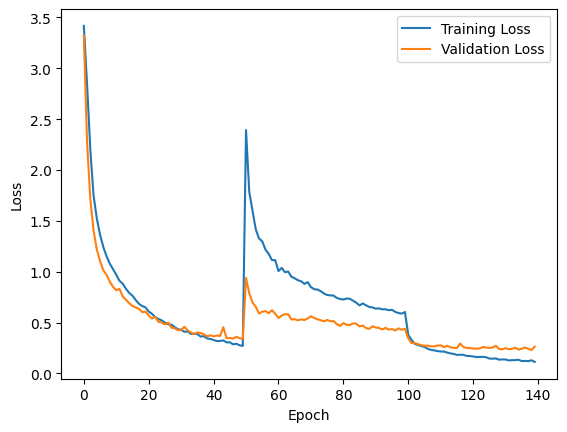

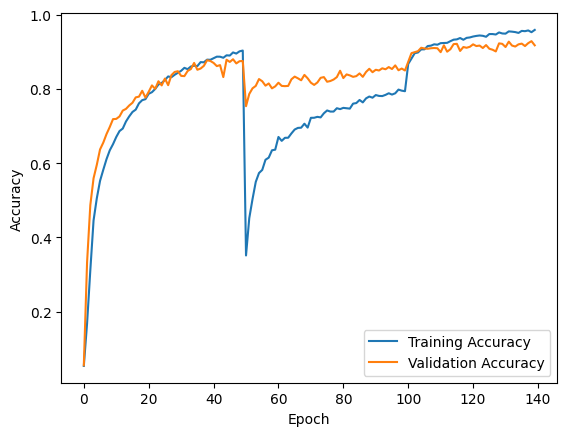

In [57]:
modelAug.plot_loss_history()
modelAug.plot_accuracy_history()

48/48 [==============================] - 1s 27ms/step


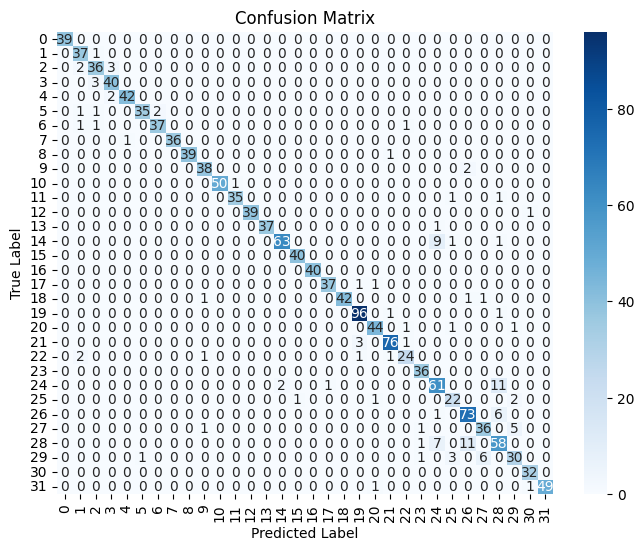

In [55]:
modelAug.plot_confusion_matrix(X_test, y_test_)

Evaluate the model on the test set

In [58]:
modelAug.evaluate(X_test, y_test_)

48/48 [==============================] - 2s 50ms/step - loss: 0.2614 - accuracy: 0.9197


[0.261404424905777, 0.9197368621826172]